# Tutorial for performing NAS with AMBER2 in PyTorch

We give an example of searching over network architectures using a typical network structure in PyTorch.

First, we shall construct the network in PyTorch, independently of AMBER2.

Then, we will design a modeler function that allows us to convert sampled indices into various values of hyperparameters for our model. 

This will allow us to use `RecurrentRLController` and its corresponding `ModelSpace` to perform an automated search over a variety of network architectures.

We demonstrate this workflow on image classification using the [MNIST](http://yann.lecun.com/exdb/mnist/) database.
Because this task is simple, we add some constraints to decrease model performance in order to showcase the ability of NAS; namely we:

1. reduce the number of classifier updates by increasing batch size and decreasing number of classifier-training epochs
2. decrease the maximum number of nodes in each hidden layer of the classifier
3. allow for the sampling of architectures with high levels of dropout

## Table of Contents

1. [Create Network (`ResMLP`)](#Create-Network)
2. [Create `ModelSpace` and `Controller`](#Create-ModelSpace-and-Controller)
3. [Perform NAS](#Perform-NAS)

In [1]:
DATA_PATH = "/common/zhangz2lab/honige/data/" # MNIST is in this directory

BASE_HIDDEN_SIZE = 16                         # Minimum size of the hidden layers in our model. The actual size will be a multiple of this number. Smaller means more compression --> training is harder.
DEVICE = 'cuda'

AMBER_EPOCHS = 25                             # Number of epochs to conduct AMBER NAS
MODELS_PER_AMBER_EPOCH = 4                    # Number of models sampled by controller per NAS epoch
MODEL_EPOCHS = 5                              # Number of epochs to train each sampled model during NAS

In [2]:
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import time
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
from amber.architect import IntegerModelVariable, ModelSpace
from amber.architect.controller import RecurrentRLController

if not torch.cuda.is_available():
    DEVICE = 'cpu'

# ref: https://github.com/lucidrains/vit-pytorch/blob/main/examples/cats_and_dogs.ipynb
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        try:
            torch.backends.cudnn.deterministic = True
        except:
            print("Failed to set torch.backends.cudnn.deterministic to True")
        pass

seed_everything(42)

In [3]:
ds_train = MNIST(root=DATA_PATH, train=True, download=True, transform=transforms.ToTensor())
ds_test = MNIST(root=DATA_PATH, train=False, download=True, transform=transforms.ToTensor())

dl_train = DataLoader(ds_train, batch_size=len(ds_train) // 2, shuffle=True, pin_memory=True) # larger batch size means fewer model updates --> training is harder.
dl_test = DataLoader(ds_test, batch_size=len(ds_test), shuffle=False, pin_memory=True)

A quick look at the data

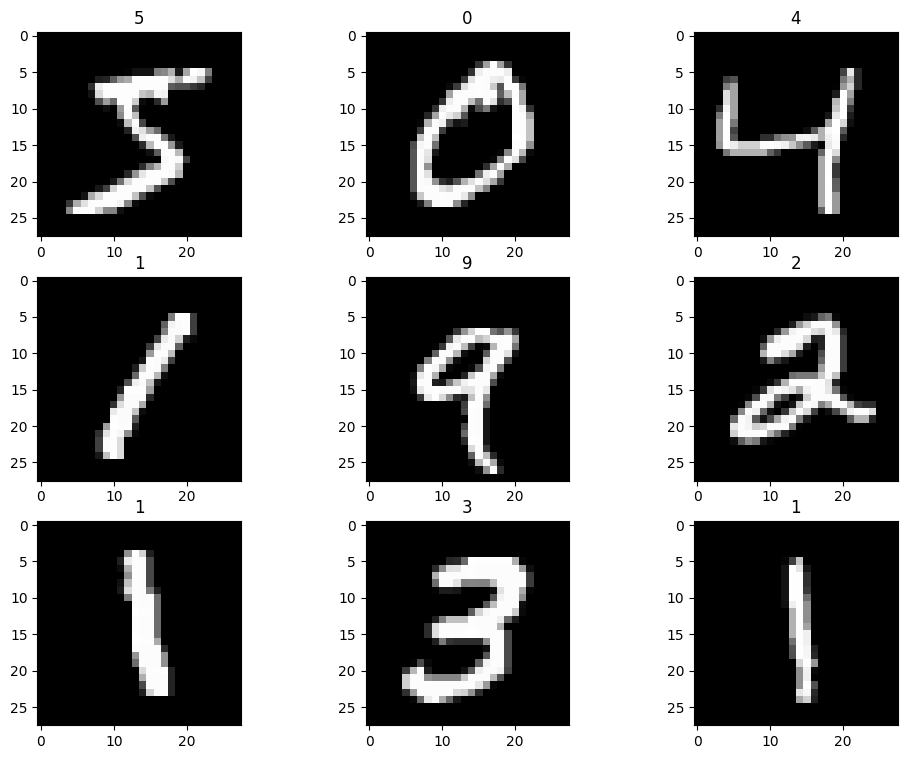

In [4]:
random_idx = np.random.randint(1, len(ds_train), size=9)
fig, axes = plt.subplots(3, 3, figsize=(12, 9))

for idx, ax in enumerate(axes.ravel()):
    img, label = ds_train[idx]
    ax.set_title(label)
    ax.imshow(img.reshape(28, 28), cmap="gray")

## Create Network

In [5]:
# A simple "block" for our model
class LinearActDrop(nn.Module):
    def __init__(self, in_features, out_features, act=nn.LeakyReLU(), p=0.1):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)
        self.act = act
        self.dropout = nn.Dropout(p)
    
    def forward(self, x):
        return self.dropout(self.act(self.linear(x)))

# A residual MLP that is built using the "blocks" above. Note there is zero dependency on AMBER: this is pure pytorch
class ResMLP(nn.Module):
    def __init__(self, hidden_size, in_size=28*28, out_size=10, num_hlayers=1, activation=nn.LeakyReLU(), dropout=0.1):
        super().__init__()
        self.in_size = in_size
        self.hidden_size = hidden_size
        self.out_size = out_size
        self.in_layer = LinearActDrop(in_size, hidden_size, act=activation, p=dropout)
        self.layers = nn.ModuleList(
            [LinearActDrop(hidden_size, hidden_size, act=activation, p=dropout) for _ in range(num_hlayers)]
        )
        self.out_layer = LinearActDrop(hidden_size, out_size, act=activation, p=0.)
    
    def forward(self, x):
        x = self.in_layer(x.flatten(1))
        for layer in self.layers:
            x = x + layer(x)
        x = self.out_layer(x)
        return x

# A simple class for training and testing a model
class Trainer():
    def __init__(self, model, criterion, optimizer, dl_train, dl_test, device=DEVICE):
        self.model = model.to(device)
        self.criterion = criterion
        self.optimizer = optimizer
        self.dl_train = dl_train
        self.dl_test = dl_test
        self.device = device
        self.history = {"train_loss": [], "test_loss": [], "test_acc": []}
    
    def train(self, epochs, verbose=True):
        for epoch in range(epochs):
            self.model.train()
            train_loss = 0
            for x, y in self.dl_train:
                x, y = x.to(self.device), y.to(self.device)
                yhat = self.model(x)
                loss = self.criterion(yhat, y)
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(self.dl_train)
            self.history["train_loss"].append(train_loss)
            test_loss, test_acc = self.test()
            self.history["test_loss"].append(test_loss)
            self.history["test_acc"].append(test_acc)
            if verbose:
                print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

    @torch.no_grad()
    def test(self):
        self.model.eval()
        targets = []
        preds = []
        for x, y in self.dl_test:
            x, y = x.to(self.device), y.to(self.device)
            yhat = self.model(x)
            targets.append(y)
            preds.append(yhat)
        targets = torch.cat(targets)
        preds = torch.cat(preds)
        test_loss = self.criterion(preds, targets).item()
        test_acc = (preds.argmax(1) == targets).float().mean().item()
        return test_loss, test_acc
    

### Check if our `Trainer` (and `ResMLP`) work

In [6]:
model = ResMLP(BASE_HIDDEN_SIZE)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
trainer = Trainer(model, criterion, optimizer, dl_train, dl_test)
trainer.train(2)

Epoch 1/2, Train Loss: 2.3018, Test Loss: 2.2901, Test Acc: 0.1384
Epoch 2/2, Train Loss: 2.2848, Test Loss: 2.2653, Test Acc: 0.2147


## Create `ModelSpace` and `Controller`

In [7]:
model_space = ModelSpace.from_list([
    IntegerModelVariable(name="hidden_size_multiplier", min=0, max=9), # used to obtain "hidden_size" for the model
    IntegerModelVariable(name="num_hlayers", min=0, max=8),            # number of residual layers, no processing needed (0 corresponds to 1 hidden layer)
    IntegerModelVariable(name="activation", min=0, max=4),             # we will map these integers to activations
    IntegerModelVariable(name="dropout", min=0, max=9),                # we will divide this by 10 to get dropout probability
])

# Maps integers to activations
def idx2act(i):
    if i == 0:
        return nn.LeakyReLU()
    elif i == 1:
        return nn.ReLU()
    elif i == 2:
        return nn.SiLU()
    elif i == 3:
        return nn.Tanh()
    elif i == 4:
        return nn.GELU()

# Our model builder: converts architecture to model
def arc2net(arc, model_space):
    # Create dictionary of keyword arguments for architecture
    arc_dict = {x:i for i,x in zip(arc, model_space)}
    # Convert hidden_size_multiplier to hidden_size (use pop() since hidden_size_multiplier is not a kwarg for ResMLP)
    arc_dict["hidden_size"] = (arc_dict.pop("hidden_size_multiplier") + 1) * BASE_HIDDEN_SIZE
    arc_dict["activation"] = idx2act(arc_dict["activation"])
    arc_dict["dropout"] /= 10
    return ResMLP(**arc_dict)

# A function to train and test a model given an architecture
def train_and_test_arc(arc, model_space, num_model_epochs=MODEL_EPOCHS):
    model = arc2net(arc, model_space)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    trainer = Trainer(model, criterion, optimizer, dl_train, dl_test)
    trainer.train(num_model_epochs, verbose=False)
    test_loss, test_acc = trainer.test()
    return model, test_loss, test_acc

# A plotting utility to visualize the reward history
def plot_rewards(reward_list, title='NAS Reward History', xlab='Architecture Iteration', ylab='Reward (Accuracy)'):
    fig_reward1, ax_reward1 = plt.subplots()
    ax_reward1.plot(reward_list)
    ax_reward1.set_xlabel(xlab)
    ax_reward1.set_ylabel(ylab)
    ax_reward1.set_title(title)
    plt.tight_layout()
    plt.show()

# A class to keep track of the reward (and architecture) history
class RewardHist():
    def __init__(self, average_frequency=MODELS_PER_AMBER_EPOCH):
        self.average_frequency = average_frequency
        self.reward_average = []
        self.arcs_all = []
        self.reward_all = []
    
    def update(self, arc, reward):
        self.arcs_all.append(arc)
        self.reward_all.append(reward)
        if len(self.reward_all) % self.average_frequency == 0:
            self.reward_average.append(sum(self.reward_all[-self.average_frequency:]) / self.average_frequency)

    @property
    def converged(self):
        return len(set(tuple(a) for a in self.arcs_all[-self.average_frequency:])) == 1 # check if last few architectures are the same

# Timer to check how long NAS takes
class Timer():
    def __init__(self):
        self.t0 = time.time()
        self.t1 = self.t0

    def __call__(self, end=True):
        if end:
            self.t1 = time.time()
        t_taken = self.t1 - self.t0
        t_hrs, t_mins = divmod(t_taken, 3600)
        t_mins, t_secs = divmod(t_mins, 60)
        return f'{int(t_hrs):02d}:{int(t_mins):02d}:{int(t_secs):02d} (HH:MM:SS)'
    
controller = RecurrentRLController(
            model_space=model_space,
            with_skip_connection=False,
            lstm_size=64,
            lstm_num_layers=1,
            # the hyperparameters below are important
            batch_size=3,         # number of samples (arcs & rewards) processed in one controller training call
            buffer_size=15,       # maximum number of samples stored in the buffer
            train_pi_iter=5,      # number of updates to the controller in one training call
            temperature=2.5,
            rescale_advantage_by_reward=True
)

## Perform NAS

NAS trial  1, r_bias=nan, arc=[4 0 4 7], test_loss=1.9030, reward=0.6380
NAS trial  2, r_bias=nan, arc=[1 8 0 7], test_loss=2.3025, reward=0.0980
NAS trial  3, r_bias=nan, arc=[4 7 0 0], test_loss=1.3173, reward=0.6343
NAS trial  4, r_bias=nan, arc=[4 3 2 0], test_loss=1.7582, reward=0.6309
NAS trial  5, r_bias=0.5003, arc=[2 0 0 7], test_loss=2.0125, reward=0.5213
NAS trial  6, r_bias=0.5003, arc=[3 2 4 4], test_loss=1.8712, reward=0.5654
NAS trial  7, r_bias=0.5003, arc=[9 7 3 3], test_loss=1.1424, reward=0.8595
NAS trial  8, r_bias=0.5003, arc=[2 5 4 4], test_loss=1.7818, reward=0.4414
NAS trial  9, r_bias=0.5003, arc=[1 1 0 8], test_loss=2.1047, reward=0.3939
NAS trial 10, r_bias=0.5003, arc=[4 2 0 2], test_loss=1.7905, reward=0.5267
NAS trial 11, r_bias=0.5003, arc=[6 2 3 5], test_loss=1.4581, reward=0.8179
NAS trial 12, r_bias=0.5003, arc=[0 0 4 5], test_loss=2.1650, reward=0.4057
NAS trial 13, r_bias=0.5067, arc=[9 0 0 0], test_loss=1.6771, reward=0.6923
NAS trial 14, r_bias=0.5

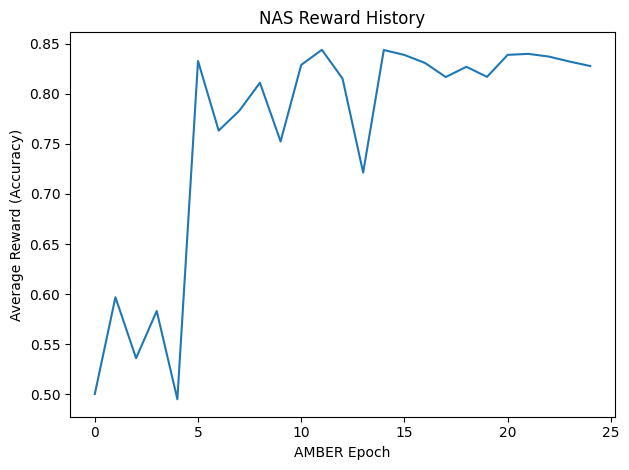

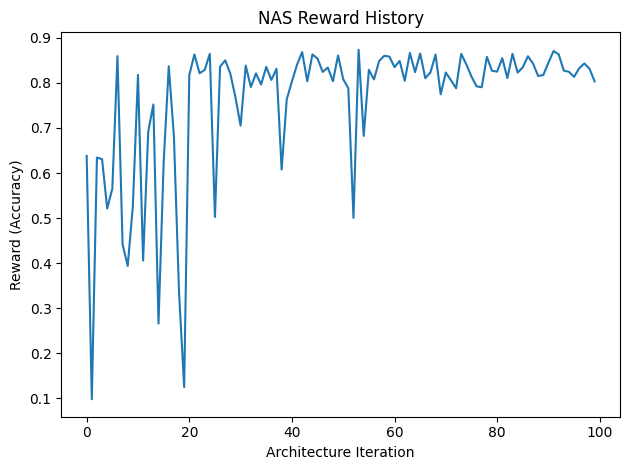

In [8]:
time_amber = Timer()
reward_hist = RewardHist()
for ep in range(AMBER_EPOCHS):
    for i in range(MODELS_PER_AMBER_EPOCH):
        arc, prob = controller.sample()
        model, test_loss, reward = train_and_test_arc(arc, model_space)
        controller.store(action=arc, prob=prob, reward=reward)
        reward_hist.update(arc, reward)
        print(f"NAS trial {ep*MODELS_PER_AMBER_EPOCH+i+1:2d}, r_bias={controller.buffer.r_bias or math.nan:.4f}, arc={arc}, test_loss={test_loss:.4f}, reward={reward:.4f}")
    controller.train()        # Train controller using sampled architectures and rewards
    if reward_hist.converged: # If the last few architectures are the same, we should stop
        print(f'AMBER NAS converged to arc={arc} in {ep} epochs')
        break
print(f'AMBER NAS took {time_amber()}')
plot_rewards(reward_hist.reward_average, xlab="AMBER Epoch", ylab="Average Reward (Accuracy)")
plot_rewards(reward_hist.reward_all, xlab = "Architecture Iteration", ylab = "Reward (Accuracy)")